## Load Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn.apionly as sns
import bootstrap_contrast as bs 
# note this is different from `bootstrapContrast` in versions prior to v0.30.

import pandas as pd
import numpy as np
import scipy as sp

## Create dummy dataset

Here, we create a dummy dataset to illustrate how `bootstrap-contrast` functions.
We first create it as a 'wide' dataset, where each column corresponds to a group of observations, and each row is simply an index number referring to an observation.

In [2]:
dataset=list()
for seed in [10,11,12,13,14,15]:
    np.random.seed(seed) # fix the seed so we get the same numbers each time.
    dataset.append(np.random.randn(40))
df=pd.DataFrame(dataset).T
cols=['Control','Group1','Group2','Group3','Group4','Group5']
df.columns=cols
# Create some upwards/downwards shifts.
df['Group2']=df['Group2']-0.1
df['Group3']=df['Group3']+0.2
df['Group4']=(df['Group4']*1.1)+4
df['Group5']=(df['Group5']*1.1)-1
# Add gender column.
df['Gender']=np.concatenate([np.repeat('Male',20),np.repeat('Female',20)])

Note that we have 6 groups of observations, with an additional non-numerical column indicating gender.

## The `bootstrap` class

In `bootstrap-contrast` v0.3, I introduce a new class called `bootstrap`. Essentially, it will compute the summary statistic and its associated confidence interval using bootstrapping. It can do this for a single group of observations, or for two groups of observations (both paired and unpaired).

Below, I obtain the bootstrapped contrast for 'Control' and 'Group1' in `df`.

In [3]:
contr=bs.bootstrap(df['Control'],df['Group1'])

As mentioned above, `contr` is a `bootstrap` object. Calling it directly will not produce anything.

In [4]:
contr

It has several callable attributes. Of interest is its `results` attribute, which returns a dictionary summarising the results of the contrast computation.

In [5]:
contr.results

{'bca_ci_high': 0.24548837217502079,
 'bca_ci_low': -0.5877837620341424,
 'ci': 95.0,
 'is_difference': True,
 'is_paired': False,
 'stat_summary': -0.18080446527038216}

`is_paired` indicates the two arrays are paired (or repeated) observations. This is indicated by the `paired` flag.

In [6]:
contr_paired=bs.bootstrap(df['Control'],df['Group1'],
                         paired=True)
contr_paired.results

{'bca_ci_high': 0.2315358954772489,
 'bca_ci_low': -0.56709424589376278,
 'ci': 95.0,
 'is_difference': True,
 'is_paired': True,
 'stat_summary': -0.1808044652703821}

`is_difference` basically indicates if one or two arrays were passed to the `bootstrap` function. Obseve what happens if we just give one array.

In [7]:
just_control_=bs.bootstrap(df['Control'])
just_control_.results

{'bca_ci_high': 0.48092618004349924,
 'bca_ci_low': -0.12687439021613289,
 'ci': 95.0,
 'is_difference': False,
 'is_paired': False,
 'stat_summary': 0.1717562151007304}

Here, the confidence interval is with respect to the mean of the group `Control`.


There are several other statistics the `bootstrap` object contains. Please do have a look at its documentation. Below, I print the p-values for `contr_paired` as an example.


In [8]:
contr_paired.pvalue_2samp_paired_ttest

0.39310007728828344

In [9]:
contr_paired.pvalue_wilcoxon

0.35369319267722144

## Producing Plots

Version 0.3 of `bootstrap-contrast` has an optimised version of the `contrastplot` command.

### Gardner-Altman floating contrast plots

Below we produce three aligned Gardner-Altman floating contrast plots. 

The `contrastplot` command will return 2 objects: a matplotlib `Figure` and a pandas `DataFrame`.
In the Jupyter Notebook, with `%matplotlib inline`, the figure should automatically appear.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


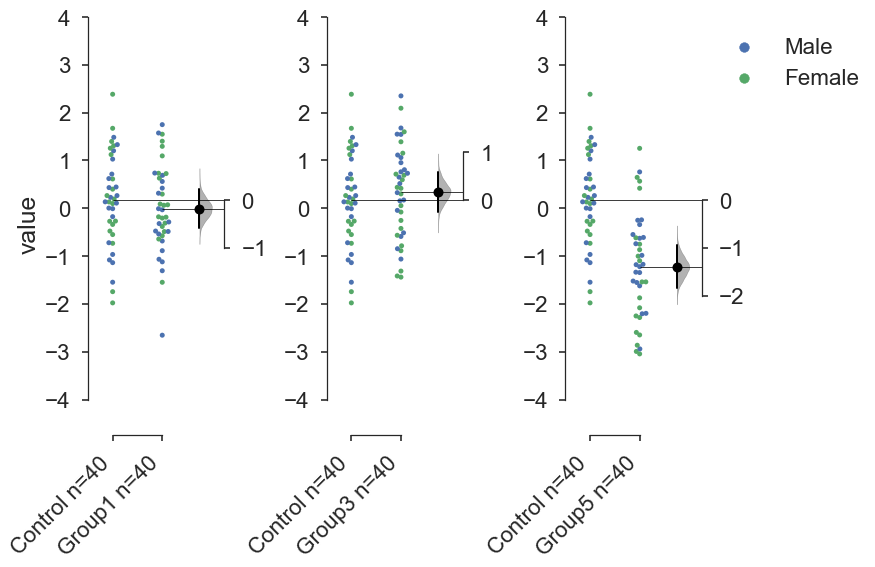

In [10]:
f,b=bs.contrastplot(df,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
    color_col='Gender',
)

The pandas `DataFrame` returned by `bs.bootstrap` contains all the (pairwise) comparisons made in the course of generating the plot, with confidence intervals (95% by default) and relevant p-values.

In [11]:
b

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_1samp_ttest,pvalue_2samp_ind_ttest,pvalue_2samp_paired_ttest,pvalue_mannWhitney,pvalue_wilcoxon
0,Control,Group1,-0.180804,-0.583302,0.223463,95.0,True,False,NIL,3.959867e-01,NIL,3.631777e-01,NIL
1,Control,Group3,0.168796,-0.244889,0.586373,95.0,True,False,NIL,4.394990e-01,NIL,4.161598e-01,NIL
2,Control,Group5,-1.397284,-1.830624,-0.934402,95.0,True,False,NIL,4.761711e-08,NIL,4.267387e-07,NIL


`bs.bootstrap` will automatically drop any NaNs in the data. 

In [12]:
# make a copy of the data
df2=df.copy()
# add nans randomly
for j,c in enumerate(cols):
    # get a random number of rows to set as NaNs
    np.random.seed(20+j)
    numNan=np.random.randint(10) 
    # get indices (number=numNan) to set as NaNs.
    np.random.seed(21+j)
    idx=np.random.randint(0,39,numNan)
    df2.loc[idx,c]=np.nan

In [13]:
df2

,Control,Group1,Group2,Group3,Group4,Group5,Gender
0,1.331587,NaN,0.372986,NaN,5.706473,-1.343561,Male
1,0.715279,-0.286073,-0.781426,0.953766,4.087105,NaN,Male
2,-1.545400,-0.484565,0.142439,0.155497,4.191374,-1.171499,Male
3,-0.008384,-2.653319,-1.800736,NaN,3.920430,-1.551969,Male
4,NaN,NaN,0.653143,1.545102,NaN,-0.740874,Male
5,-0.720086,-0.319631,-1.634721,0.732338,4.159146,-2.939966,Male
6,0.265512,-0.536629,-0.094873,1.550188,2.348715,NaN,Male
7,0.108549,0.315403,-0.220228,1.061211,4.232220,-2.196542,Male
8,0.004291,NaN,-0.906982,1.678686,3.385974,-1.335687,Male
9,NaN,-1.065603,NaN,-0.845377,5.192982,-1.521123,Male


/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


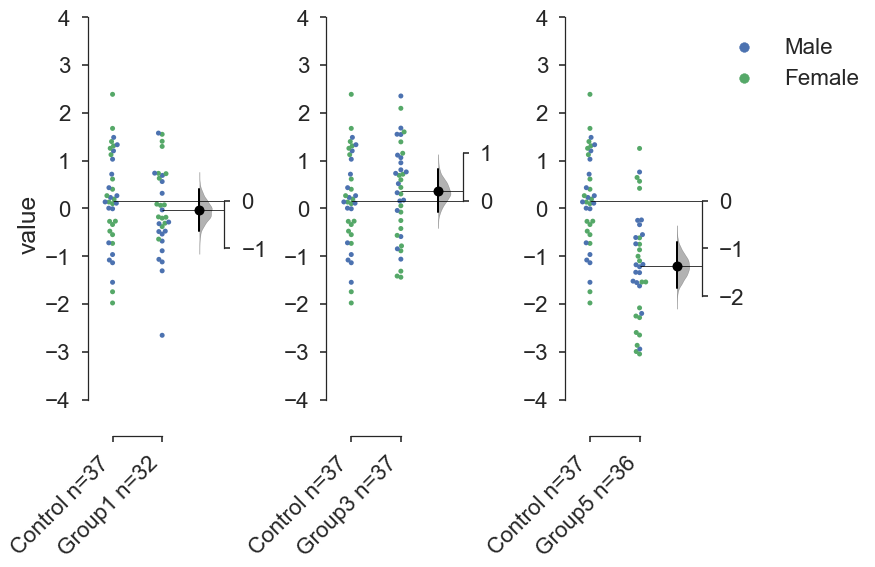

In [14]:
f,b=bs.contrastplot(df2,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
    color_col='Gender',
)

Note how the Ns (appended to the group names in the xtick labels) indicate the number of datapoints being plotted, and used to calculate the contrasts.


We can also display paired data.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


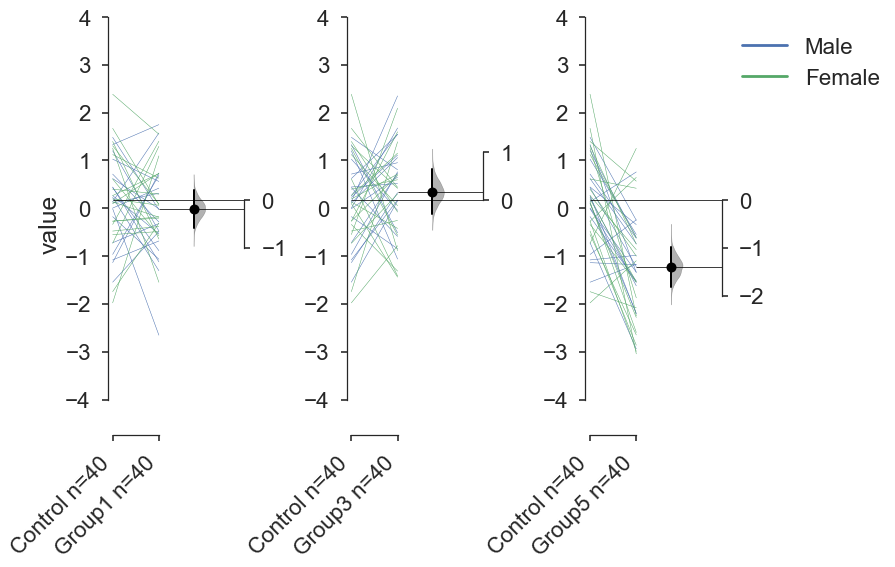

In [15]:
f,b=bs.contrastplot(df,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
                    color_col='Gender',
                    paired=True
)

If you want to plot the raw swarmplot instead of the paired lines, use the `show_pairs` flag to set this.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


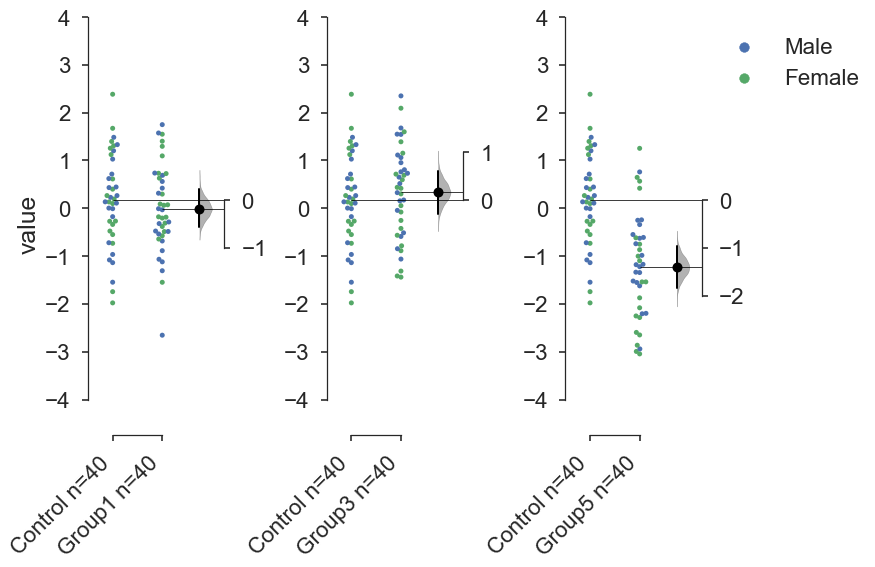

In [16]:
f,b=bs.contrastplot(df,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
                    color_col='Gender',
                    paired=True,
                    show_pairs=False
)

The contrasts computed will still be paired, as indicated by the DataFrame produced.

In [17]:
b

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_1samp_ttest,pvalue_2samp_ind_ttest,pvalue_2samp_paired_ttest,pvalue_mannWhitney,pvalue_wilcoxon
0,Control,Group1,-0.180804,-0.570014,0.226075,95.0,True,True,NIL,NIL,3.931001e-01,NIL,0.353693
1,Control,Group3,0.168796,-0.290572,0.610817,95.0,True,True,NIL,NIL,4.786384e-01,NIL,0.510138
2,Control,Group5,-1.397284,-1.834472,-0.960863,95.0,True,True,NIL,NIL,2.114260e-07,NIL,0.000004


To use custom colors, the `custom_palette` flag takes a list of `matplotlib` color names, or RGB tuples.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


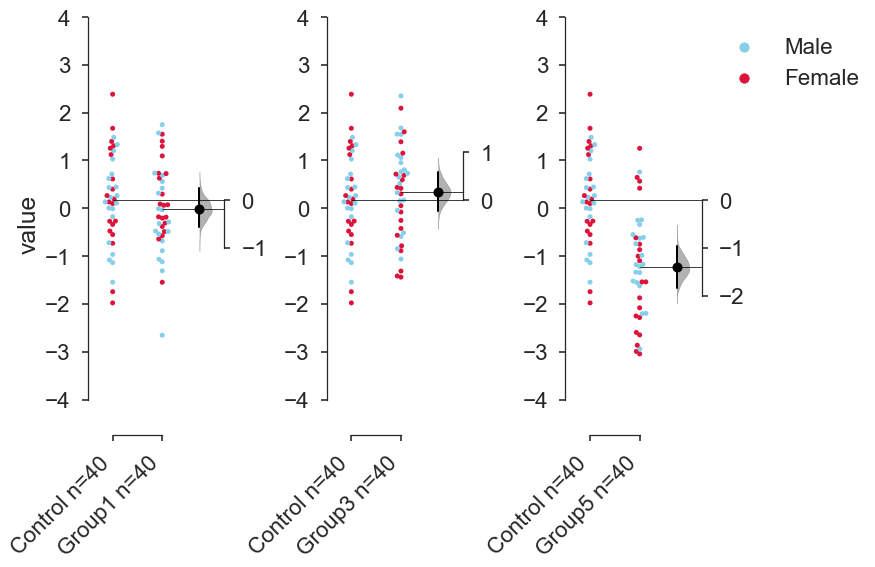

In [18]:
f,b=bs.contrastplot(df,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
                    color_col='Gender',
                    custom_palette=['skyblue','crimson']
)

`bs.contrastplot` can also work with 'melted' or 'longform' data. This term is so used because each row will now correspond to a single datapoint, with one column carrying the value (`value`) and other columns carrying 'metadata' describing that datapoint (in this case, `group` and `Gender`).

For more details on wide vs long or 'melted' data, see
https://en.wikipedia.org/wiki/Wide_and_narrow_data

In [19]:
x='group'
y='some_metric'
color_col='Gender'
# To read more about melting a dataframe,
# see https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html
df_melt=pd.melt(df.reset_index(),
                id_vars=['index',color_col],
                value_vars=cols,value_name=y,var_name=x)

If you are using a melted DataFrame, you will need to specify the `x` (containing the categorical group names) and `y` (containing the numerical values for plotting) columns.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


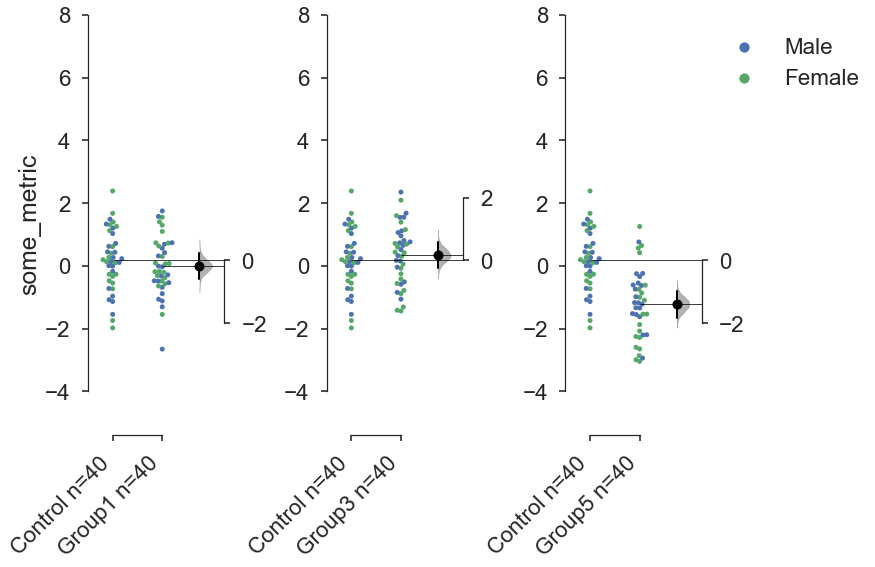

In [20]:
f,b=bs.contrastplot(df_melt,
                    x='group',
                    y='some_metric',
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
                    color_col='Gender',
)

### Cummings contrast and hub-and-spoke plots.

A Cummings contrast plot.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


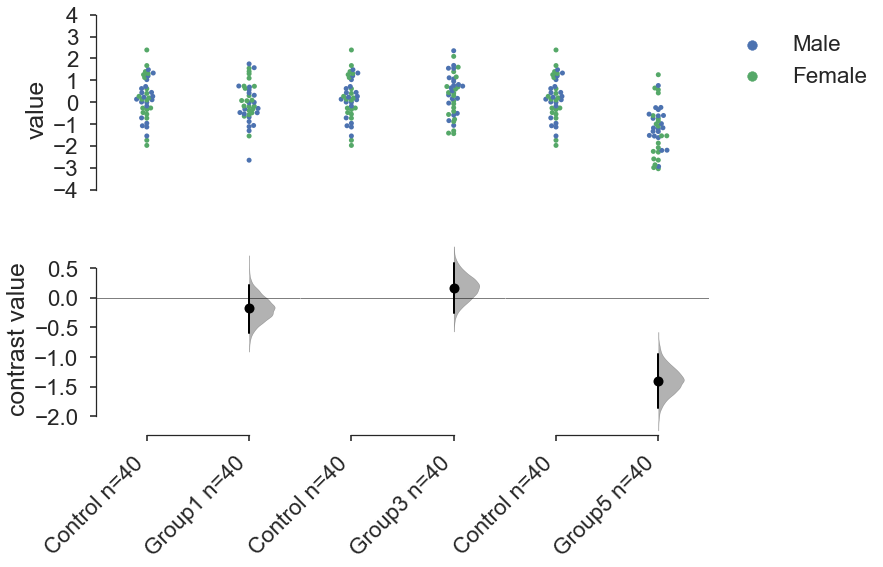

In [21]:
f,b=bs.contrastplot(df,
                    idx=(('Control','Group1',),('Control','Group3'),('Control','Group5')),
                    color_col='Gender',
                    float_contrast=False
)

A Cummings hub-and-spoke contrast plot, where all groups are compared relative to the very first category in each tuple.

/Users/josesho/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


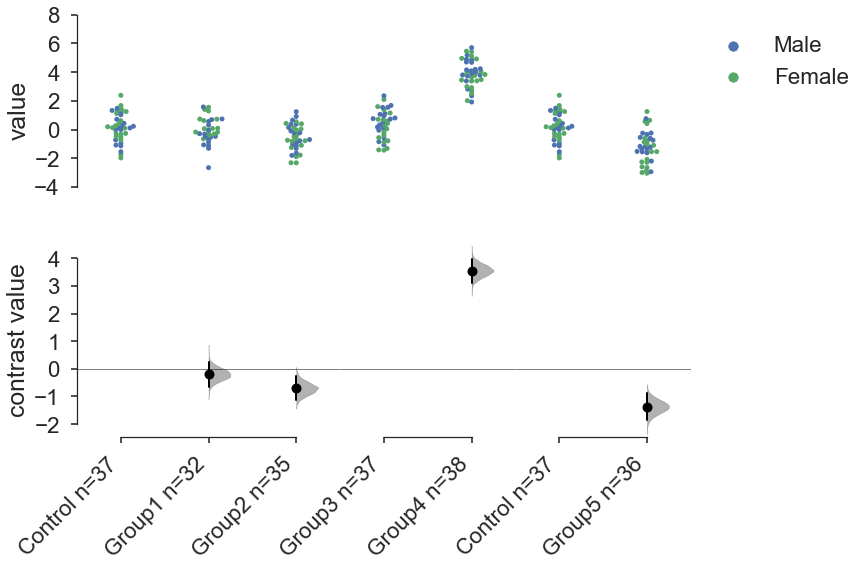

In [22]:
f,b=bs.contrastplot(df2,
                    idx=(('Control','Group1','Group2'),('Group3','Group4'),
                         ('Control','Group5')),
                    color_col='Gender',
)